In [1]:
%load_ext autoreload
%autoreload 2

#### model

In [ ]:
#hardware
device = 'cuda:0'

from circuit_pruner.utils import load_config

config = load_config('./configs/alexnet_sparse_config.py')
model = config.model.to(device)



#general
import torch
import os
from copy import deepcopy
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names

#### feature target

In [3]:
nodeid = 905

from circuit_pruner.utils import filterid_2_perlayerid

layer_num,unit,layer = filterid_2_perlayerid(nodeid,model)

feature_targets = {layer:[unit]}

#### extract general circuit

In [4]:
general_ranks = torch.load('quick_start/features_10_9_alexnetsparse_actgrad_ranks.pt')

In [6]:
import pickle
df = pickle.load(open('quick_start/circuit_with_force_and_mag_df.pkl','rb'))

In [7]:
df.loc[(df['model']=='alexnet_sparse') & (df['layer']==layer) & (df['method']=='actxgrad') & (df['unit']==unit)][['sparsity','effective_sparsity','pruned_pearson']]

,sparsity,effective_sparsity,pruned_pearson
31782,0.001,0.000038,0.141962
31783,0.005,0.001754,0.252371
31784,0.010,0.005277,0.301975
31785,0.050,0.045890,0.140092
31786,0.100,0.099406,0.503945
31787,0.200,0.199840,0.838351
31788,0.300,0.299917,0.964347
31789,0.400,0.399988,0.995799
31790,0.500,0.499897,0.999939
31791,0.600,0.599785,0.999999


In [10]:
from circuit_pruner.extraction import model_ranks_2_circuit_model
from circuit_pruner.utils import circuit_2_model_sparsity

sparsity = .5

general_circuit,general_mask = model_ranks_2_circuit_model(general_ranks,sparsity,model,
                                                                     feature_targets,device,structure='edges',
                                                                     use_effective_mask=True)

general_circuit = general_circuit.eval().to('cpu')

for l in general_mask:
    l = l.to('cpu')
    
    
circuit_feature_targets = {layer:[0]}
circuit_unit = 0

general_circuit_sparsity_factor = circuit_2_model_sparsity(general_circuit,model)

features_10 effective last layer
target sparsity: 0.5
total params to feature: 184768

kept params in original mask: 92384      (total params * sparsity)
original mask: 1018231 params
effective mask: 1018060 params
effective_sparsity: 0.49989175614825077
filter sparsity: 0.8249696917215102
kernel sparsity: 0.6059516624242265


In [11]:
general_circuit_sparsity_factor

0.49989175614825077

###### or use model instead of general circuit

In [122]:
# circuit_feature_targets = {layer:[unit]}
# general_circuit = model
# circuit_unit = unit
# general_circuit_sparsity_factor = 1

#### feature visualization of circuit

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

100%|██████████| 512/512 [00:21<00:00, 23.80it/s]



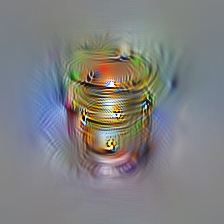

(13, 13)
(6, 6)
[(30.0, 193.0), (30.0, 193.0)]


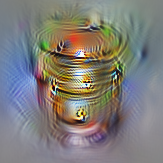

In [11]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field


featviz_in_recep_field(deepcopy(general_circuit),layer,circuit_unit,margin=0)

#### dataloading

In [12]:
image_root_folder = os.path.abspath('image_data/sample_data/polysemantic/'+layer+':'+str(unit)+'/')

clusters = ['cluster_0','cluster_1']


#You can run the control experiment by uncommenting the following line:

#clusters = ['mixed_0','mixed_1']

if (clusters == ['mixed_0','mixed_1']) and not (os.path.exists(image_root_folder+'/mixed_0')):

    from circuit_pruner.utils import mix_image_folders
    
    mix_image_folders(image_root_folder,['cluster_0','cluster_1'],clusters)
    


from circuit_pruner.data_loading import rank_image_data
from circuit_pruner.data_loading import single_image_data
from torchvision import transforms
from torch.utils import data


dataloaders = {}

#make 'general' filter dataloader
kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


for cluster in clusters:

    dataloaders[cluster] = data.DataLoader(rank_image_data(image_root_folder+'/'+cluster,
                                            config.preprocess,
                                            class_folders=False),
                                            batch_size=5,
                                            shuffle=False,
                                            **kwargs)



#### generate ranks

In [13]:
from circuit_pruner.dissected_Conv2d import set_across_model, set_model_target_node
from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model
from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model

structure = 'kernels'

ranks = {}


for cluster in clusters:
    print(cluster)
    
    rankable_model = dissect_model(deepcopy(general_circuit), dissect=True,store_ranks = True, device=device)
    rankable_model.to(device)

    set_model_target_node(rankable_model,layer,circuit_unit)

    #we want to get ranks with respect to the maximum activation in each image, these why these image sets
    #where constructed, and its based on these activation locations that the images were clustered
    set_across_model(rankable_model,'rank_field','max')
    

    set_across_model(rankable_model,'absolute_rank',True)
    
    iter_dataloader = iter(dataloaders[cluster])
    iters = len(iter_dataloader)

    #actually extract ranks by running images through model
    clear_ranks_across_model(rankable_model)

    for it in range(iters):

        inputs, label = next(iter_dataloader)
        inputs = inputs.to(device)

        rankable_model.zero_grad()

        try:
            outputs = rankable_model(inputs)
        except:
            pass


    ranks[cluster] = get_ranklist_from_dissected_Conv2d_modules(rankable_model)
    
    del rankable_model
    torch.cuda.empty_cache()

cluster_0
cluster_1


In [64]:
general_circuit

Sequential(
  (features_0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (features_1): ReLU(inplace=True)
  (features_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (features_4): ReLU(inplace=True)
  (features_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_7): ReLU(inplace=True)
  (features_8): Conv2d(384, 172, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_9): ReLU(inplace=True)
  (features_10): Conv2d(172, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

#### activation preservation as function of sparsity

##### dataloaders with larger batchsize

In [65]:
dataloaders = {}

#make 'general' filter dataloader
kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


for cluster in clusters:

    dataloaders[cluster] = data.DataLoader(rank_image_data(image_root_folder+'/'+cluster,
                                            config.preprocess,
                                            class_folders=False),
                                            batch_size=40,
                                            shuffle=False,
                                            **kwargs)


In [ ]:
from circuit_pruner.extraction import get_preservation_at_sparsities
import numpy as np

ranker = ranks

structure='kernels'

sparsities = np.linspace(.9999, .01, num=10)
#in paper num is set to '70' here, but that takes times


model_sparsities = []
for sparsity in sparsities:
    model_sparsities.append(sparsity*general_circuit_sparsity_factor) 


scores = {}
for cluster in clusters:
    scores[cluster+'_circuit'] = {}

for rank_cluster in clusters:
    for data_cluster in clusters:
        print('\n\n\n')
        print(rank_cluster)
        print(data_cluster)
        print('\n\n\n')
        scores[rank_cluster+'_circuit'][data_cluster+'_data'] = get_preservation_at_sparsities(
            
                                                                general_circuit,
                                                                ranker[rank_cluster],
                                                                circuit_feature_targets,
                                                                dataloaders[data_cluster],
                                                                sparsities,device,metric='all',
                                                                rank_field = 'orig_max',
                                                                structure=structure)


In [82]:
means = {}

for cluster in clusters:
    means[cluster+'_data'] = scores[cluster+'_circuit'][cluster+'_data'][layer+':0']['avg_diff'][6]/scores[cluster+'_circuit'][cluster+'_data'][layer+':0']['mean_normed_diff'][6]

{'cluster_0_data': 19.367302, 'cluster_1_data': 19.025387}

In [84]:
import plotly.graph_objects as go
import plotly.express as px

x_axis = model_sparsities

metric = 'avg_abs_diff'
mean_norm = True

color_dict = {
               clusters[0]+'_circuit':px.colors.qualitative.T10[0],
               clusters[1]+'_circuit':px.colors.qualitative.T10[1],
             }


fig = go.Figure()
##SET WIDTH TO 40 FOR BIG PLOT
for circuit in scores:
    for data in scores[circuit]:
        # Create and style traces
        if data.replace('_data','') == circuit.replace('_circuit',''):
            linetype = None
        else:
            linetype = 'dot'
            
        name = (circuit+' : '+data).replace('_',' ').replace('1','2').replace('0','1').replace('data','images')
        y = np.array(scores[circuit][data]['%s:%s'%(layer,0)][metric])
        if mean_norm:
            y = y/means[data]
        x = x_axis[0:len(scores[circuit][data]['%s:%s'%(layer,0)][metric])]
        fig.add_trace(go.Scatter(x=x, y=y, name=name,
                         line=dict(color=color_dict[circuit], width=4,dash=linetype)))

# Edit the layout
fig.update_layout( width = 720,
                   plot_bgcolor = 'rgba(255,255,255,1)',
                   paper_bgcolor = 'rgba(255,255,255,1)',
                   xaxis_title='sparsity',
                   yaxis_title=r'${\Delta\mathcal{F}_{norm}}$',
                  legend=dict(
                                yanchor="top",
                                y=0.95,
                                xanchor="left",
                                x=0.03,
                                bgcolor='rgba(255,255,255,0.3)'
                              )
                 )

fig.update_xaxes(autorange="reversed",gridcolor='rgb(210,210,210)',gridwidth=1)
fig.update_yaxes(gridcolor='rgb(210,210,210)',gridwidth=1)

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [.5, .4, .3, .2, .1]
    )
)


fig.show()

#### extract circuit at particular sparsity

In [85]:
# extraction at last good sparsity

from circuit_pruner.extraction import model_ranks_2_circuit_model

ranker = ranks


#sparsities are with respect to the general circuit, not the original model

target_sparsities = {'cluster_0':0.268,
                     'cluster_1':0.211,
                     'mixed_0':0.311,
                     'mixed_1':0.368
                     }


sparse_circuits = {}
sparse_masks = {}

for cluster in clusters:
    sparse_circuit,sparse_mask = model_ranks_2_circuit_model(ranker[cluster],target_sparsities[cluster],
                                                           general_circuit,circuit_feature_targets,device,
                                                           structure='kernels',use_effective_mask=True,
                                                           rank_field='max')
    sparse_circuits[cluster] = sparse_circuit.to(device)
    sparse_masks[cluster] = sparse_mask


features_10 effective last layer
target sparsity: 0.268
total params to feature: 152428

we found 60064 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 92364    (after subtracting previously masked params)
kept params in original mask: 24754      (total params * sparsity)
original mask: 316050 params
effective mask: 315071 params
effective_sparsity: 0.26684639036854185
features_10 effective last layer
target sparsity: 0.211
total params to feature: 152428

we found 60064 params that were already zero'd out, your model is already a pruned circuit right? . . . 			   just making sure, we are subtracting these params from the total.

new total params: 92364    (after subtracting previously masked params)
kept params in original mask: 19489      (total params * sparsity)
original mask: 257609 params
effective mask: 256178 params
effective_sparsity: 0.2092806721

In [86]:
from circuit_pruner.visualizer.featureviz  import featviz_in_recep_field

In [87]:
keys = list(sparse_circuits.keys())

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

100%|██████████| 512/512 [00:19<00:00, 26.74it/s]



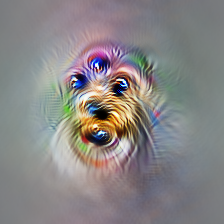

(13, 13)
(6, 6)
[(30.0, 193.0), (30.0, 193.0)]


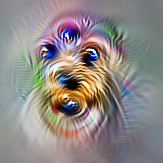

In [88]:
featviz_in_recep_field(deepcopy(sparse_circuits[keys[0]]),layer,0,margin=0)

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

100%|██████████| 512/512 [00:18<00:00, 27.37it/s]



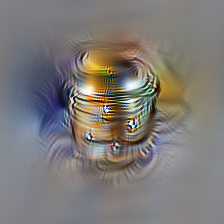

(13, 13)
(6, 6)
[(30.0, 193.0), (30.0, 193.0)]


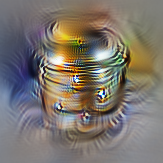

In [89]:
featviz_in_recep_field(deepcopy(sparse_circuits[keys[1]]),layer,0,margin=0)

#### Compare IoU of extracted circuits

In [90]:
from circuit_pruner.utils import plot_iou_from_masks

In [91]:
iou_fig = plot_iou_from_masks(sparse_masks[keys[0]],sparse_masks[keys[1]])

In [92]:
iou_fig